# Churn modelling

The churn model provides a predictive estimate of the likelihood that a customer quit interacting with the company.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import ADASYN
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import shap
import warnings
warnings.filterwarnings("ignore")

/shared-libs/python3.9/py/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Import the dataset and drop customer ID column:

In [ ]:
df = pd.read_csv('churn.csv')
df = df.drop('customer_id', axis=1)
df

,churn,yes_review,age,days_from_activation,yes_refund,Recency,Monetary,gender_male,region_abruzzo,region_basilicata,...,region_sicilia,region_toscana,region_trentino alto adige,region_umbria,region_valle d'aosta,region_veneto,loyalty_type_business premium,loyalty_type_business standard,loyalty_type_premium,loyalty_type_standard
0,0,1,45,0,0,0,125.35,1,0,0,...,1,0,0,0,0,0,0,0,0,1
1,0,1,38,56,0,22,96.17,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,43,467,0,217,135.25,0,0,1,...,0,0,0,0,0,0,0,1,0,0
3,0,1,47,55,1,49,0.00,1,0,0,...,0,0,0,0,0,1,0,0,0,1
4,0,0,38,371,1,362,0.00,0,0,0,...,1,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70419,1,1,44,432,0,5,1.54,0,0,0,...,0,0,0,0,0,0,0,0,1,0
70420,1,0,45,399,0,1,13.50,0,0,0,...,0,0,0,0,0,0,0,1,0,0
70421,1,0,40,412,0,3,72.95,0,0,0,...,0,0,0,0,0,0,0,0,0,1
70422,1,0,38,362,0,3,16.89,0,0,0,...,0,0,0,0,0,0,0,0,1,0


We normalise the numerical variables to a range of 0-1 and divide the data into training (80%) and test set (20%):

In [ ]:
x = df.drop('churn', axis=1)
y = df['churn']

columns_to_normalize = ['age', 'days_from_activation', 'Recency', 'Monetary']
x[columns_to_normalize] = MinMaxScaler().fit_transform(x[columns_to_normalize])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

Looking at the distribution of churners in the training set, we see that we are in an unbalanced class problem (90% non-churners and 10% churners):

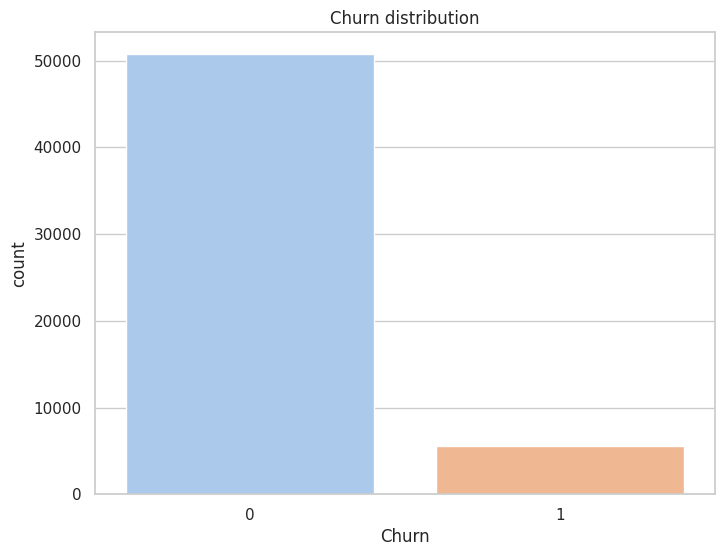

In [ ]:
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))

sns.countplot(x=y_train, palette='pastel')

plt.xlabel('Churn')
plt.title('Churn distribution')

plt.show()

In [ ]:
y_train.value_counts() # CLASS IMBALANCE! 90-10

0    50721
1     5618
Name: churn, dtype: int64

We solve the class imbalance problem by an oversampling procedure of the minority class, using the ADASYN algorithm, whose steps are: 
- Compute the k-nearest neighbors for each minority class instance.
- Calculate the imbalance ratio, which is the ratio of the number of majority class instances to the number of minority class instances.
- For each minority class instance, compute a density distribution based on the number of neighbors in the majority and minority classes.
- Calculate the desired number of synthetic samples for each minority instance based on the density distribution.
- Generate synthetic samples for each minority instance based on the desired number.

In [ ]:
# Oversampling with ADASYN
adasyn = ADASYN(sampling_strategy='minority', random_state=42)
x_adasyn, y_adasyn = adasyn.fit_resample(x_train, y_train)

In [ ]:
y_adasyn.value_counts() # balanced post oversampling

1    50962
0    50721
Name: churn, dtype: int64

Let's now define the classification models.

## Logistic model

In [ ]:
logistic_model = LogisticRegression(random_state=42)

In [ ]:
logistic_model.fit(x_adasyn, y_adasyn)
y_pred_log = logistic_model.predict(x_test)

See the performance of logistic model on the test set:

In [ ]:
print(classification_report(y_test, y_pred_log))

              precision    recall  f1-score   support

           0       0.97      0.73      0.83     12652
           1       0.25      0.78      0.38      1433

    accuracy                           0.74     14085
   macro avg       0.61      0.76      0.60     14085
weighted avg       0.89      0.74      0.79     14085



In [ ]:
accuracy_log = accuracy_score(y_test, y_pred_log)
precision_log = precision_score(y_test, y_pred_log)
recall_log = recall_score(y_test, y_pred_log)
f1_log = f1_score(y_test, y_pred_log)
auc_log = roc_auc_score(y_test, logistic_model.predict_proba(x_test)[:, 1])

print('Logistic Accuracy:', accuracy_log)
print('Logistic Precision:', precision_log)
print('Logistic Recall:', recall_log)
print('Logistic F1-score:', f1_log)
print('Logistic AUC:', auc_log)

Logistic Accuracy: 0.7351082712105076
Logistic Precision: 0.24691629955947136
Logistic Recall: 0.782274947662247
Logistic F1-score: 0.37535576762096096
Logistic AUC: 0.8295697659103127


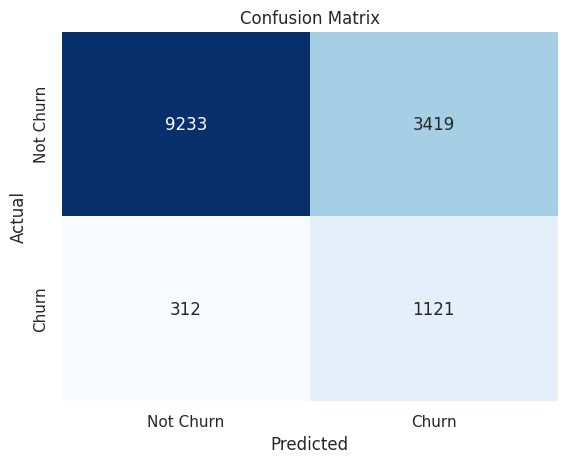

In [ ]:
cm = confusion_matrix(y_test, y_pred_log)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Not Churn', 'Churn'], yticklabels=['Not Churn', 'Churn'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Decision Tree

In [ ]:
dt_model = DecisionTreeClassifier(random_state=42)

In [ ]:
dt_model.fit(x_adasyn, y_adasyn)
y_pred_dt = dt_model.predict(x_test)

See the performance of decision tree model on the test set:

In [ ]:
print(classification_report(y_test, y_pred_dt))

              precision    recall  f1-score   support

           0       0.93      0.88      0.91     12652
           1       0.29      0.44      0.35      1433

    accuracy                           0.84     14085
   macro avg       0.61      0.66      0.63     14085
weighted avg       0.87      0.84      0.85     14085



In [ ]:
accuracy_dt = accuracy_score(y_test, y_pred_dt)
precision_dt = precision_score(y_test, y_pred_dt)
recall_dt = recall_score(y_test, y_pred_dt)
f1_dt = f1_score(y_test, y_pred_dt)
auc_dt = roc_auc_score(y_test, dt_model.predict_proba(x_test)[:, 1])

print('Decision Tree Accuracy:', accuracy_dt)
print('Decision Tree Precision:', precision_dt)
print('Decision Tree Recall:', recall_dt)
print('Decision Tree F1-score:', f1_dt)
print('Decision Tree AUC:', auc_dt)

Decision Tree Accuracy: 0.8361377351792687
Decision Tree Precision: 0.2943112364833098
Decision Tree Recall: 0.4368457780879274
Decision Tree F1-score: 0.351685393258427
Decision Tree AUC: 0.6591042042510455


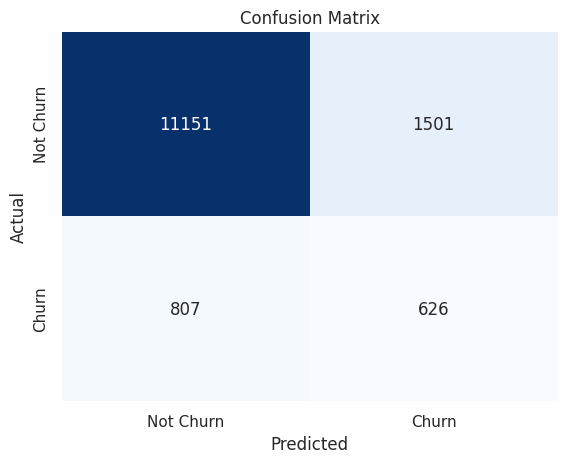

In [ ]:
cm = confusion_matrix(y_test, y_pred_dt)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Not Churn', 'Churn'], yticklabels=['Not Churn', 'Churn'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Random Forest

In [ ]:
rf_model = RandomForestClassifier(random_state=42)

In [ ]:
rf_model.fit(x_adasyn, y_adasyn)
y_pred_rf = rf_model.predict(x_test)

See the performance of random forest model on the test set:

In [ ]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.95      0.86      0.91     12652
           1       0.34      0.61      0.43      1433

    accuracy                           0.84     14085
   macro avg       0.64      0.74      0.67     14085
weighted avg       0.89      0.84      0.86     14085



In [ ]:
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)
auc_rf = roc_auc_score(y_test, rf_model.predict_proba(x_test)[:, 1])

print('Random Forest Accuracy:', accuracy_rf)
print('Random Forest Precision:', precision_rf)
print('Random Forest Recall:', recall_rf)
print('Random Forest F1-score:', f1_rf)
print('Random Forest AUC:', auc_rf)

Random Forest Accuracy: 0.8382676606318779
Random Forest Precision: 0.33668341708542715
Random Forest Recall: 0.6078157711095603
Random Forest F1-score: 0.4333333333333333
Random Forest AUC: 0.8664515003489184


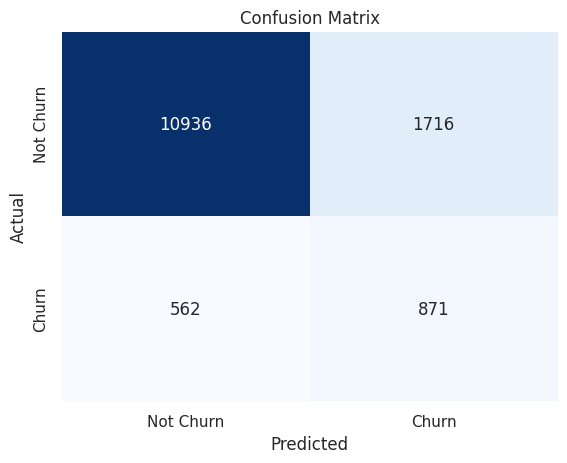

In [ ]:
cm = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Not Churn', 'Churn'], yticklabels=['Not Churn', 'Churn'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## XGBoost

In [ ]:
xgb_model = xgb.XGBClassifier(random_state=42)

In [ ]:
xgb_model.fit(x_adasyn, y_adasyn)
y_pred_xgb = xgb_model.predict(x_test)

See the performance of XGBoost model on the test set:

In [ ]:
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.95      0.90      0.92     12652
           1       0.37      0.54      0.44      1433

    accuracy                           0.86     14085
   macro avg       0.66      0.72      0.68     14085
weighted avg       0.89      0.86      0.87     14085



In [ ]:
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
precision_xgb = precision_score(y_test, y_pred_xgb)
recall_xgb = recall_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb)
auc_xgb = roc_auc_score(y_test, xgb_model.predict_proba(x_test)[:, 1])

print('XGBoost Accuracy:', accuracy_xgb)
print('XGBoost Precision:', precision_xgb)
print('XGBoost Recall:', recall_xgb)
print('XGBoost F1-score:', f1_xgb)
print('XGBoost AUC:', auc_xgb)

XGBoost Accuracy: 0.8613418530351438
XGBoost Precision: 0.3743961352657005
XGBoost Recall: 0.5408234473133287
XGBoost F1-score: 0.44247787610619466
XGBoost AUC: 0.878598006785982


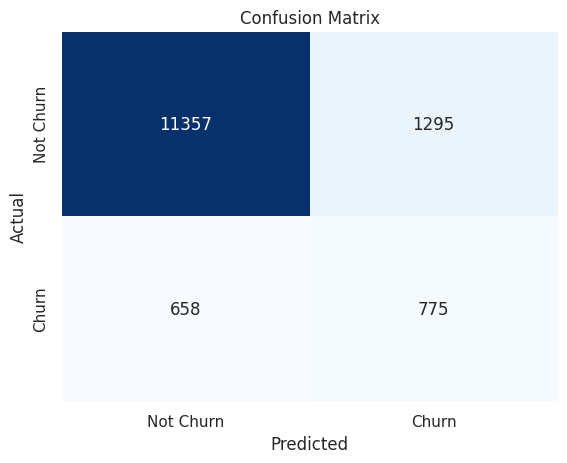

In [ ]:
cm = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Not Churn', 'Churn'], yticklabels=['Not Churn', 'Churn'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Multilayer Perceptron

In [ ]:
mlp_model = MLPClassifier(hidden_layer_sizes=(5,), random_state=42) # 5 hidden layer

In [ ]:
mlp_model.fit(x_adasyn, y_adasyn)
y_pred_mlp = mlp_model.predict(x_test)

See the performance of Multilayer Perceptron model on the test set:

In [ ]:
print(classification_report(y_test, y_pred_mlp))

              precision    recall  f1-score   support

           0       0.98      0.68      0.80     12652
           1       0.24      0.91      0.38      1433

    accuracy                           0.70     14085
   macro avg       0.61      0.79      0.59     14085
weighted avg       0.91      0.70      0.76     14085



In [ ]:
accuracy_mlp = accuracy_score(y_test, y_pred_mlp)
precision_mlp = precision_score(y_test, y_pred_mlp)
recall_mlp = recall_score(y_test, y_pred_mlp)
f1_mlp = f1_score(y_test, y_pred_mlp)
auc_mlp = roc_auc_score(y_test, mlp_model.predict_proba(x_test)[:, 1])

print('Multilayer Perceptron Accuracy:', accuracy_mlp)
print('Multilayer Perceptron Precision:', precision_mlp)
print('Multilayer Perceptron Recall:', recall_mlp)
print('Multilayer Perceptron F1-score:', f1_mlp)
print('Multilayer Perceptron AUC:', auc_mlp)

Multilayer Perceptron Accuracy: 0.7035143769968051
Multilayer Perceptron Precision: 0.24330900243309003
Multilayer Perceptron Recall: 0.9071877180739707
Multilayer Perceptron F1-score: 0.3837072018890201
Multilayer Perceptron AUC: 0.8647711380209809


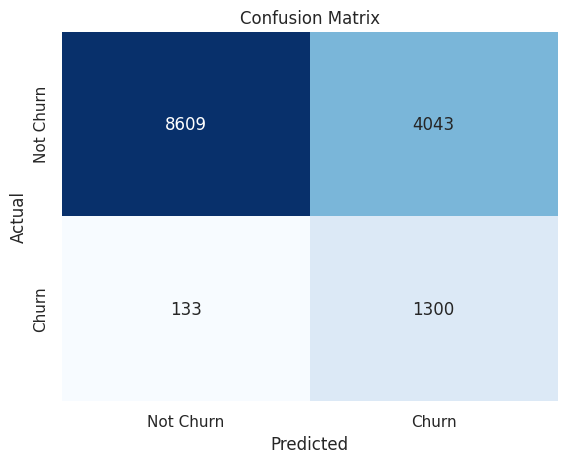

In [ ]:
cm = confusion_matrix(y_test, y_pred_mlp)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Not Churn', 'Churn'], yticklabels=['Not Churn', 'Churn'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## ROC curves

In [ ]:
y_prob_log = LogisticRegression(random_state=42).fit(x_adasyn, y_adasyn).predict_proba(x_test)[:,1]
y_prob_dt = DecisionTreeClassifier(random_state=42).fit(x_adasyn, y_adasyn).predict_proba(x_test)[:,1]
y_prob_rf = RandomForestClassifier(random_state=42).fit(x_adasyn, y_adasyn).predict_proba(x_test)[:,1]
y_prob_xgb = xgb.XGBClassifier(random_state=42).fit(x_adasyn, y_adasyn).predict_proba(x_test)[:,1]
y_prob_mlp = MLPClassifier(hidden_layer_sizes=(5,), random_state=42).fit(x_adasyn, y_adasyn).predict_proba(x_test)[:,1]

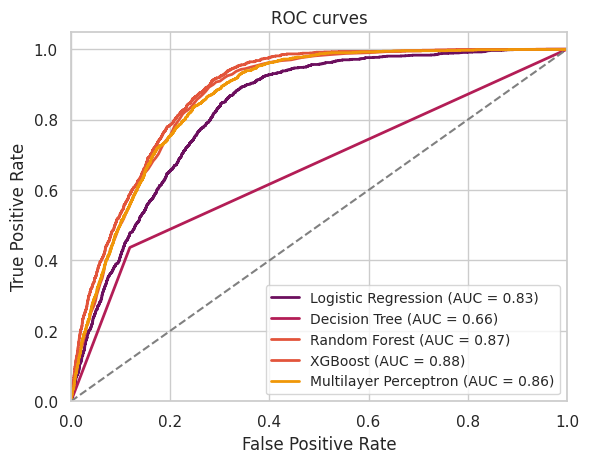

In [ ]:
fpr_log, tpr_log, _ = roc_curve(y_test, y_prob_log)
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_prob_dt)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_prob_xgb)
fpr_mlp, tpr_mlp, _ = roc_curve(y_test, y_prob_mlp)

plt.plot(fpr_log, tpr_log, color='#6c0f5e', lw=2, label='Logistic Regression (AUC = {:.2f})'.format(auc_log))
plt.plot(fpr_dt, tpr_dt, color='#b31d56', lw=2, label='Decision Tree (AUC = {:.2f})'.format(auc_dt))
plt.plot(fpr_rf, tpr_rf, color='#e2543b', lw=2, label='Random Forest (AUC = {:.2f})'.format(auc_rf))
plt.plot(fpr_xgb, tpr_xgb, color='#e2543b', lw=2, label='XGBoost (AUC = {:.2f})'.format(auc_xgb))
plt.plot(fpr_mlp, tpr_mlp, color='#f09708', lw=2, label='Multilayer Perceptron (AUC = {:.2f})'.format(auc_mlp))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves')
plt.legend(loc='lower right', fontsize='small')
plt.show()

The best performing model is the XGBoost.
Let us therefore see which variables are the most decisive in classifying the observations:

In [ ]:
feature_importance = xgb_model.feature_importances_

feature_importance_df = pd.DataFrame({'Feature': x.columns, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print("Feature Importance:")
feature_importance_df.head()

Feature Importance:


,Feature,Importance
3,yes_refund,0.734879
1,age,0.060543
4,Recency,0.040624
2,days_from_activation,0.039859
5,Monetary,0.019078


The most decisive variable is 'yes_refund', which indicates whether a review has been made or not. This is followed by age, recency and so on.

Now we use SHapley Additive exPlanations (SHAP) to explain the overall behavior of the model across all predictions (global explanation).
Moreover SHAP values provide a clear and intuitive interpretation of how each feature influences the model's output. This is crucial for understanding the factors driving a particular prediction, making machine learning models more transparent and interpretable.

In [ ]:
# Explain the model's predictions using SHAP
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(x_test)

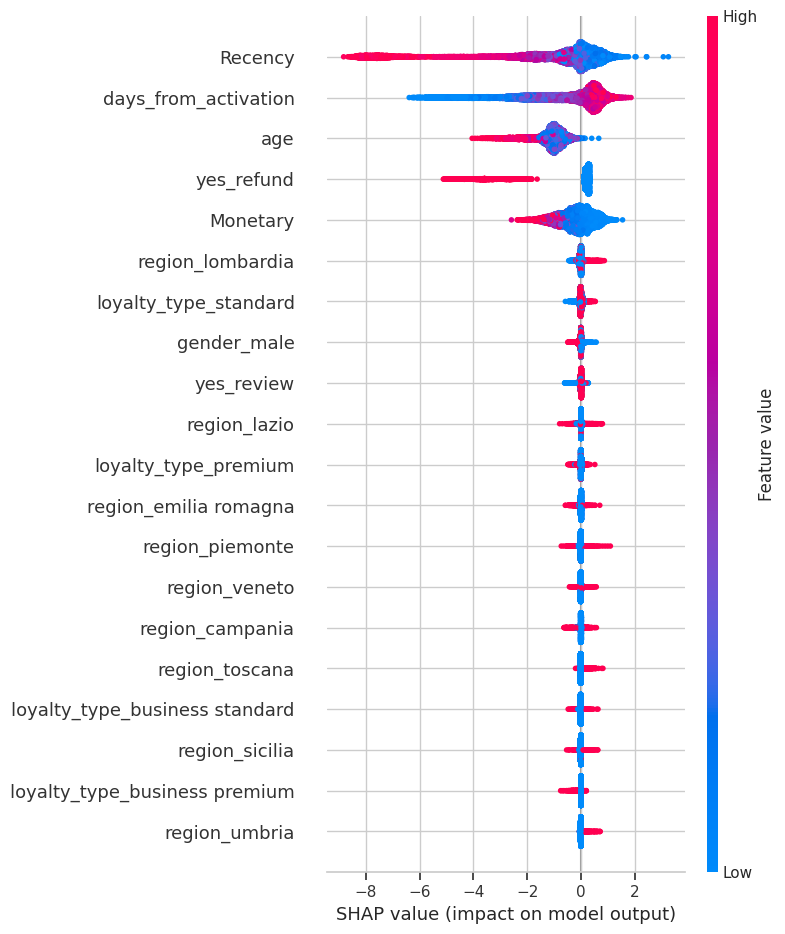

In [ ]:
# Plot summary plot using SHAP values for all predictions
shap.summary_plot(shap_values, x_test)

Each point on the plot represents a Shapley value for a feature and an instance. The position on the x-axis indicates the SHAP value, which shows the impact on the model output. A point's color represents the feature value (high or low).

As shown in the figure **Recency** has a high positive impact on the model's prediction; higher values of it decrease the prediction.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=fad4abbb-8bc7-4ee9-9f5c-63fc95d85e92' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>